In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.animation import FFMpegWriter
from numpy.random import rand
from landscape import Landscape

# Part I - Creating an appropriate landscape

## A) Erosion to Make a Model Landscape

### Large K, Small m, large n => produce steeper terrain with fewer mountains

In [37]:
def initial_conditions(NX,NY):
    Z = rand(NX,NY)
    return Z

NX = 100 #number of rows
NY = 100 #number of columns

d  = 5 # grid spacing in meters
dx = d # keep dx=dy for simplicity
dy = d

LX=NX*dx
LY=NY*dy

Z = initial_conditions(NX,NY)

x = np.arange(NX)
y = np.arange(NY)
X,Y = np.meshgrid(y,x) #strange that y goes first !!!

K = 1.0e-4
D = 0.005
uplift = 0.03 / 600.

eta = 0.125
dt = eta*dx**2/D - 5     
print(' dt[years] = ',dt)
m=0.0001
n=3 
theta_c = 1

T = 2000.0 * 625.0
n_iter = int(np.round(T/dt))
print('Number of interations: ',n_iter)

ls = Landscape(NX,NY)
ls.pool_check(Z,NX,NY)
ls.A = np.zeros((NX,NY))

 dt[years] =  620.0
Number of interations:  2016


In [38]:
def init_figure():
    fig = plt.figure(figsize=(12.,6.))
    plt.show()
    return fig

def update_figure():
        plt.clf()
        ax1 = fig.add_subplot(121,projection='3d')

        # use equal x-y aspect with an explicit vertical exageration
        vert_exag = 4.
        ax1.set_xlim3d(0,max(NX,NY))
        ax1.set_ylim3d(0,max(NX,NY))
        ax1.set_zlim3d(0,max(NX,NY) / vert_exag)

        ax1.set_title('Surface Relief x '+str(vert_exag))

#        surf = ax1.plot_surface(X,Y,Z, color='yellowgreen', rstride=1, cstride=1,
#                antialiased=False,linewidth=0)
        surf = ax1.plot_surface(X,Y,Z, cmap = cm.terrain, rstride=1, cstride=1,
                antialiased=False,linewidth=0)

        ax2 = fig.add_subplot(122,aspect='equal')
        ax2.set_title('Elevation')

        #im = ax2.pcolor(Z,cmap=cm.terrain)
        im = ax2.pcolor(Z,cmap=cm.coolwarm)
        cs = ax2.contour(Z,6,colors='k')

        # Add a color bar which maps values to colors.
        cbar = fig.colorbar(im, shrink=0.5, aspect=5)
        # Add the contour line levels to the colorbar
        cbar.add_lines(cs)

        #plt.show()
        plt.draw()
        plt.pause(0.05)

<Figure size 1200x600 with 0 Axes>

<Figure size 640x480 with 0 Axes>

 Simulation finished.


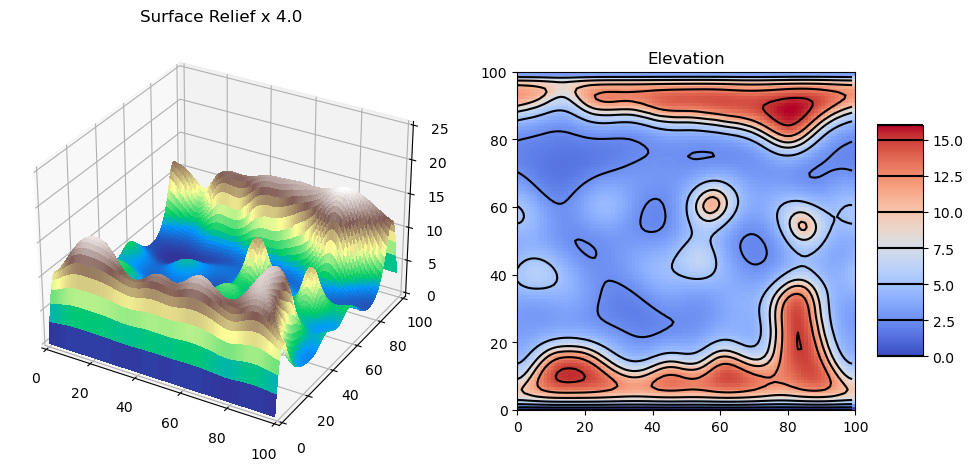

In [39]:
fig = init_figure()
Znew = np.copy(Z)

for it in range(1,200):

    ls.calculate_collection_area(Z,NX,NY)
    ls.A = ls.A*(dx*dy)

    for i in range(NX):
        iL = np.mod(i-1,NX) # normally i-1 but observe p.b.c.
        iR = np.mod(i+1,NX) # normally i+1 but observe p.b.c.

        for j in range(NY):
            jD = np.mod(j-1,NY) # normally j-1 but observe p.b.c.
            jU = np.mod(j+1,NY) # normally j+1 but observe p.b.c.

            if ls.drain[i,j]>0: #regular pointm, not a pool, not a drainage point 
                s1 = (Z[iR,j] - Z[iL,j]) / (2 * dx) ### enter gradient term 's1'
                s2 = (Z[i,jU] - Z[i,jD]) / (2 * dy) ### enter gradient term 's2'
                s3 = (Z[iR, jD] - Z[iL, jU]) / (2 * np.sqrt(dx**2 + dy**2)) ### enter gradient term 's3'
                s4 = (Z[iR,jU] - Z[iL, jD]) / (2 * np.sqrt(dx**2 + dy**2))### enter gradient term 's4'


                gradient = (np.sqrt(s1**2 + s2**2) + np.sqrt(s3**2 + s4**2)) /2 ### compute gradient from s1-s4
                Psi_z = uplift - K * ((ls.A[i,j])**m * ((np.sqrt(s1**2+s2**2) + np.sqrt(s3**2+s4**2))/2)**n - theta_c ) 

            elif ls.drainage[i,j]>0: #this cell is a drainage point (it drains a pool)

                if (Z[i,j]>=Z[iR,j]) and ls.pool[iR,j]!=ls.drainage[i,j]: 
                    gradient = (Z[i,j]-Z[iR,j])/dx #pool is on my left, I drain to the right, use this gradiant
                elif (Z[i,j]>=Z[iL,j]) and ls.pool[iL,j]!=ls.drainage[i,j]:
                    gradient = (Z[i,j]-Z[iL,j])/dx
                elif (Z[i,j]>=Z[i,jU]) and ls.pool[i,jU]!=ls.drainage[i,j]:
                    gradient = (Z[i,j]-Z[i,jU])/dy
                elif (Z[i,j]>=Z[i,jD]) and ls.pool[i,jD]!=ls.drainage[i,j]:
                    gradient = (Z[i,j]-Z[i,jD])/dy
                else:
                    gradient = 0.02 # ??? This does happen (maybe when two pools merge)

                Psi_z = uplift - K * (ls.A[i,j]**m * ((np.sqrt(s1**2+s2**2) + np.sqrt(s3**2+s4**2))/2)**n - theta_c )  ### repeat Eq. (15) from above

            else: #this cell is a pool, assume it has some mass diffusion but no erosion!
                Psi_z = 0.

            if (Psi_z<0):
                Psi_z = 0. 

                # diffusion term, derive in terms of D,Z[:,:],dx,dy
            Phi_z = D * ((Z[iR,j] - 2*Z[i,j] + Z[iL,j])/dx**2 + (Z[i,jU] - 2*Z[i,j] + Z[i, jD])/dy**2)

                # insert Phi_z, Psi_z, and uplift terms to obtain new elevation Znew[i,j]
            Znew[i,j] = Z[i,j] + ( (Psi_z + Phi_z) )*dt  

            dZdt= (Znew[i,j] - Z[i,j]) / dt
            CFL = abs(dZdt) * dt / min(dx,dy)

            if (Znew[i,j]<0.):
                Znew[i,j] = 0. # yes, this does happen at the boundary when kept at zero

    Znew[0,:] = 0.0 # resets front boundary to 0
    Z = np.copy(Znew)

    ls.pool_check(Z,NX,NY)

update_figure()
print(' Simulation finished.')

fig

## B) Applying Landscape onto Parameters

In [40]:
ff = np.copy(Z)

In [48]:
max_normalize = 0

for i in range(100):
    for j in range(100):
        if ff[i,j] > max_normalize:
               max_normalize = ff[i,j]

for i in range(100):
    for j in range(100):
        ff[i,j] = ff[i,j]/max_normalize

In [63]:
x = np.arange(10,30,0.2)
y = np.arange(-10,10,0.2)
x, y = np.meshgrid(x, y)

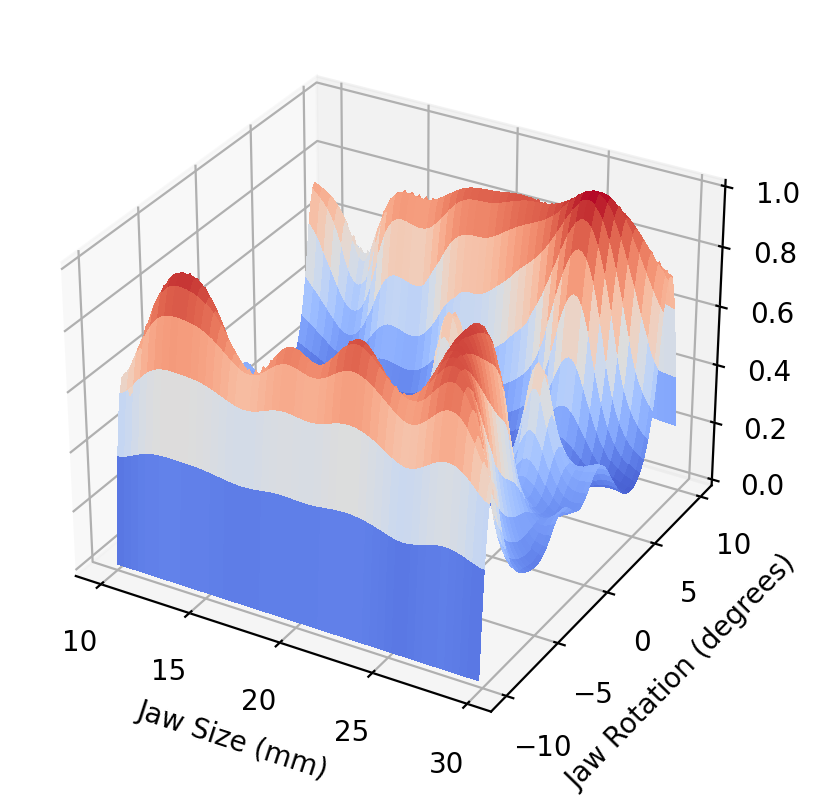

In [65]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(projection='3d')

plt.xlabel('Jaw Size (mm)')
plt.ylabel('Jaw Rotation (degrees)')
ax.plot_surface(x, y, ff, cmap=cm.coolwarm, antialiased=False)

# Part 2 - Pupfish Random Walk

## A) Functions that perform normalization of surrounding gradients such that their favorability can be evaluated under a 0-1 random number probability

In [306]:
def Normalize(F,B,L,R):
    total = abs(F) + abs(B) + abs(L) + abs(R)
    #print(F,B,L,R,total)

    F = F/total #Normalize gradient so that they can be computed as a fraction of 1
    B = B/total
    L = L/total
    R = R/total

    total = abs(F) + abs(B) + abs(L) + abs(R)
    #print(F,B,L,R,total)

    F += 1 #Normalize gradients so that they are all positive
    B += 1
    L += 1
    R += 1

    total = abs(F) + abs(B) + abs(L) + abs(R)
    #print(F,B,L,R)

    F /= total #Normalize gradients so that they are a fraction of 1 again
    B /= total
    L /= total
    R /= total
    
    return F,B,L,R

In [307]:
def NormalizeLeft(F,B,R):
    total = abs(F) + abs(B) + abs(R)
    #print(F,B,L,R,total)

    F = F/total #Normalize gradient so that they can be computed as a fraction of 1
    B = B/total
    R = R/total

    total = abs(F) + abs(B) + abs(R)
    #print(F,B,L,R,total)

    F += 1 #Normalize gradients so that they are all positive
    B += 1
    R += 1

    total = abs(F) + abs(B) + abs(R)
    #print(F,B,L,R)

    F /= total #Normalize gradients so that they are a fraction of 1 again
    B /= total
    R /= total
    
    return F,B,R

In [308]:
def NormalizeRight(F,B,L):
    total = abs(F) + abs(B) + abs(L)
    #print(F,B,L,R,total)

    F = F/total #Normalize gradient so that they can be computed as a fraction of 1
    B = B/total
    L = L/total

    total = abs(F) + abs(B) + abs(L)
    #print(F,B,L,R,total)

    F += 1 #Normalize gradients so that they are all positive
    B += 1
    L += 1

    total = abs(F) + abs(B) + abs(L)
    #print(F,B,L,R)

    F /= total #Normalize gradients so that they are a fraction of 1 again
    B /= total
    L /= total
    
    return F,B,L

In [312]:
def NormalizeForward(B,L,R):
    total = abs(B) + abs(L) + abs(R)
    #print(F,B,L,R,total)
    
    B = B/total
    L = L/total
    R = R/total

    total = abs(B) + abs(L) + abs(R)
    #print(F,B,L,R,total)

    B += 1
    L += 1
    R += 1

    total = abs(B) + abs(L) + abs(R)
    #print(F,B,L,R)

    B /= total
    L /= total
    R /= total
    
    return B,L,R

In [313]:
def NormalizeBackward(F,L,R):
    total = abs(F) + abs(L) + abs(R)
    #print(F,B,L,R,total)

    F = F/total #Normalize gradient so that they can be computed as a fraction of 1
    L = L/total
    R = R/total

    total = abs(F) + abs(L) + abs(R)
    #print(F,B,L,R,total)

    F += 1 #Normalize gradients so that they are all positive
    L += 1
    R += 1

    total = abs(F) + abs(L) + abs(R)
    #print(F,B,L,R)

    F /= total #Normalize gradients so that they are a fraction of 1 again
    L /= total
    R /= total
    
    return F,L,R

## B) Random Walk Equations

### i. First Landscape, can't perform mp4

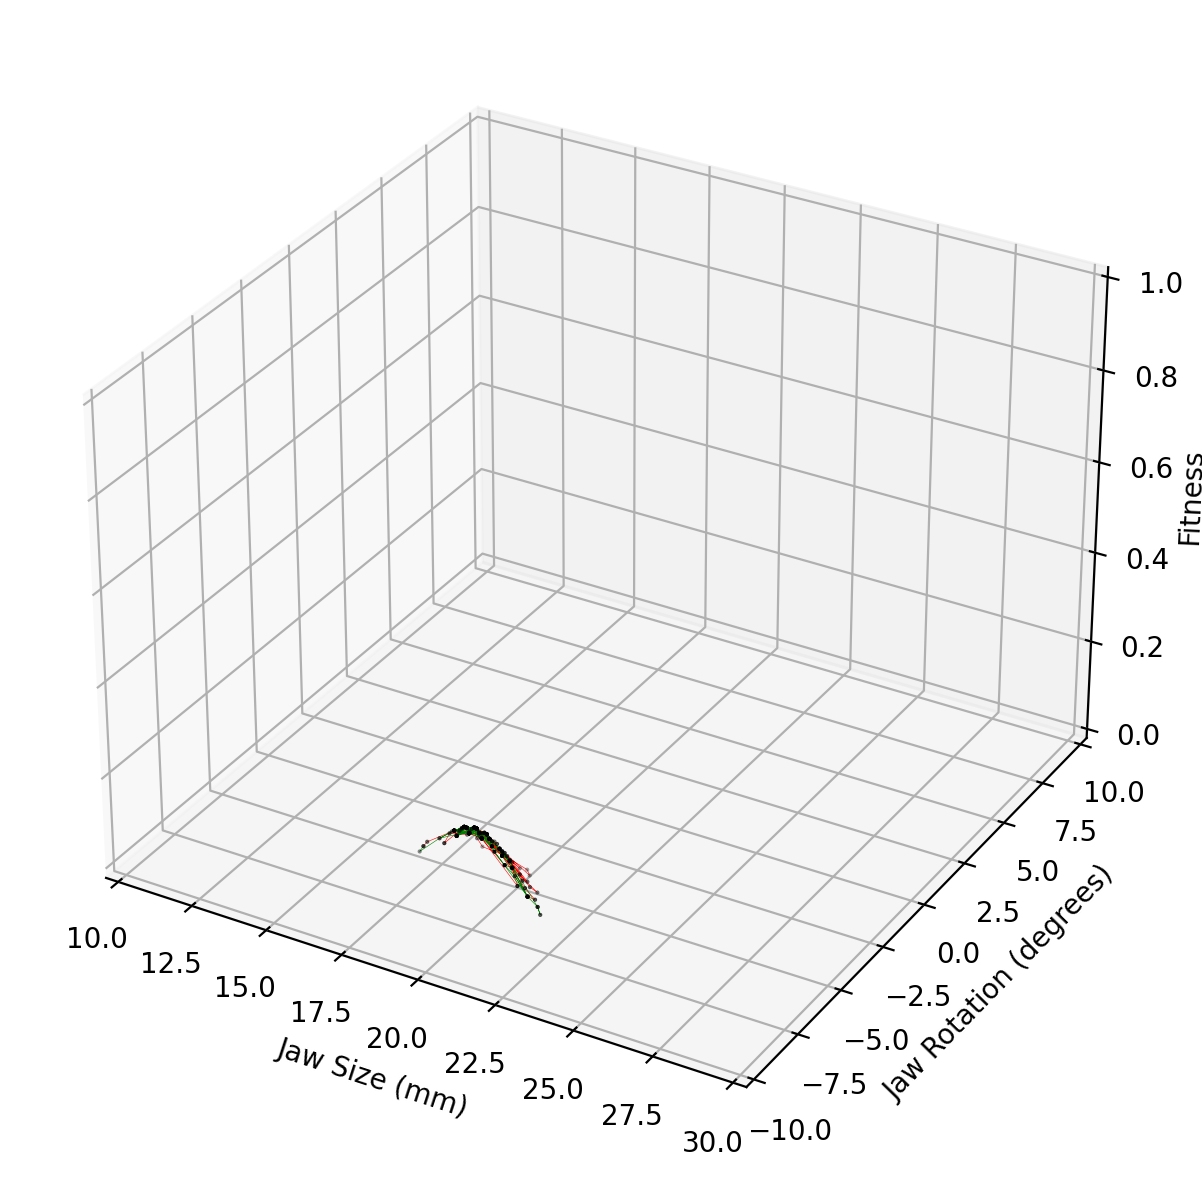

In [455]:
N = 2
dt = 10
gen = 1000
initial = np.zeros((100,100))
initial[50,0] = ff[50,0]

xnew = np.zeros(gen//dt+1)
ynew = np.zeros(gen//dt+1)
fishnew = np.zeros(gen//dt+1)

color = ('red','green','blue','magenta','yellow','orange','lime','aqua','purple')

fig = plt.figure(figsize=(8, 6), dpi=200)
ax = fig.add_subplot(projection='3d')

for lineages in range(N):
    xcord = [20]
    ycord = [-10]
    fish_real = [ff[50,0]]
    
    fish = np.copy(initial)
    for generations in range(gen):
        F = 0
        B = 0
        L = 0
        R = 0
        total = 0
        fishn = np.zeros((100,100))
        for i in range(100):
            for j in range(100):
                if fish[i,j] > 0 and 0 < i < 99 and 0 < j < 99:
                    F = ff[i+1,j] - ff[i,j] #Determine sign and magnitude of gradient
                    B = ff[i-1,j] - ff[i,j]
                    L = ff[i,j-1] - ff[i,j]
                    R = ff[i,j+1] - ff[i,j]
                    
                    F,B,L,R = Normalize(F,B,L,R)
                    
                    r = np.random.random()
                    if 0 <= r < F:
                        fishn[i+1,j] = ff[i+1,j]

                        if generations%dt == 0:
                            xcord.append((i+1)/5+10)
                            ycord.append(j/5-10)

                            fish_real.append(fishn[i+1,j])

                    elif F <= r < F+B:
                        fishn[i-1,j] = ff[i-1,j]

                        if generations%dt == 0:
                            xcord.append((i-1)/5+10)
                            ycord.append(j/5-10)

                            fish_real.append(fishn[i-1,j])

                    elif F+B <= r < F+B+L:
                        fishn[i,j-1] = ff[i,j-1]

                        if generations%dt == 0:
                            xcord.append(i/5+10)
                            ycord.append((j-1)/5-10)

                            fish_real.append(fishn[i,j-1])

                    elif F+B+L <= r < F+B+L+R:
                        fishn[i,j+1] = ff[i,j+1]

                        if generations%dt == 0:
                            xcord.append(i/5+10)
                            ycord.append((j+1)/5-10)

                            fish_real.append(fishn[i,j+1])
                            
                    fish[i,j] = 0

                elif fish[i,j] > 0 and j == 0:
                    F = ff[i+1,j] - ff[i,j] #Determine sign and magnitude of gradient
                    B = ff[i-1,j] - ff[i,j]
                    R = ff[i,j+1] - ff[i,j]
                    
                    F,B,R = NormalizeLeft(F,B,R)
                    
                    r = np.random.random()
                    if 0 <= r < F:
                        fishn[i+1,j] = ff[i+1,j]
                        
                        if generations%dt == 0:
                            xcord.append((i+1)/5+10)
                            ycord.append(j/5-10)
                        
                            fish_real.append(fishn[i+1,j])
                        
                    elif F <= r < F+B:
                        fishn[i-1,j] = ff[i-1,j]
                        
                        if generations%dt == 0:
                            xcord.append(i/5+10)
                            ycord.append((j-1)/5-10)
                        
                            fish_real.append(fishn[i-1,j])
                        
                    elif F+B <= r < F+B+R:
                        fishn[i,j+1] = ff[i,j+1]
                        
                        if generations%dt == 0:
                            xcord.append(i/5+10)
                            ycord.append((j+1)/5-10)

                            fish_real.append(fishn[i,j+1])
                        
                    fish[i,j] = 0
                    
                elif fish[i,j] > 0 and j == 99:
                    F = ff[i+1,j] - ff[i,j] #Determine sign and magnitude of gradient
                    B = ff[i-1,j] - ff[i,j]
                    L = ff[i,j-1] - ff[i,j]
                    
                    F,B,L = NormalizeRight(F,B,L)
                    
                    r = np.random.random()
                    if 0 <= r < F:
                        fishn[i+1,j] = ff[i+1,j]
                        
                        if generations%dt == 0:
                            xcord.append((i+1)/5+10)
                            ycord.append(j/5-10)
                        
                            fish_real.append(fishn[i+1,j])
                        
                    elif F <= r < F+B:
                        fishn[i-1,j] = ff[i-1,j]
                        
                        if generations%dt == 0:
                            xcord.append(i/5+10)
                            ycord.append((j-1)/5-10)
                        
                            fish_real.append(fishn[i-1,j])
                        
                    elif F+B <= r < F+B+L:
                        fishn[i,j-1] = ff[i,j-1]
                        
                        if generations%dt == 0:
                            xcord.append(i/5+10)
                            ycord.append((j+1)/5-10)

                            fish_real.append(fishn[i,j-1])
                        
                    fish[i,j] = 0
                    
                elif fish[i,j] > 0 and i == 0:
                    F = ff[i+1,j] - ff[i,j]
                    L = ff[i,j-1] - ff[i,j]
                    R = ff[i,j+1] - ff[i,j]
                    
                    F,L,R = NormalizeBackward(F,L,R)
                    
                    r = np.random.random()
                    if 0 <= r < F:
                        fishn[i+1,j] = ff[i+1,j]
                        
                        if generations%dt == 0:
                            xcord.append((i+1)/5+10)
                            ycord.append(j/5-10)
                        
                            fish_real.append(fishn[i+1,j])
                        
                    elif F <= r < F+L:
                        fishn[i,j-1] = ff[i,j-1]
                        
                        if generations%dt == 0:
                            xcord.append(i/5+10)
                            ycord.append((j-1)/5-10)
                        
                            fish_real.append(fishn[i,j-1])
                        
                    elif F+L <= r < F+L+R:
                        fishn[i,j+1] = ff[i,j+1]
                        
                        if generations%dt == 0:
                            xcord.append(i/5+10)
                            ycord.append((j+1)/5-10)

                            fish_real.append(fishn[i,j+1])
                        
                    fish[i,j] = 0
                    
                elif fish[i,j] > 0 and i == 99:
                    B = ff[i-1,j] - ff[i,j]
                    L = ff[i,j-1] - ff[i,j]
                    R = ff[i,j+1] - ff[i,j]
                    
                    B,L,R = NormalizeForward(B,L,R)
                    
                    r = np.random.random()
                    if 0 <= r < B:
                        fishn[i-1,j] = ff[i-1,j]
                        
                        if generations%dt == 0:
                            xcord.append((i+1)/5+10)
                            ycord.append(j/5-10)
                        
                            fish_real.append(fishn[i-1,j])
                        
                    elif B <= r < B+L:
                        fishn[i,j-1] = ff[i,j-1]
                        
                        if generations%dt == 0:
                            xcord.append(i/5+10)
                            ycord.append((j-1)/5-10)
                        
                            fish_real.append(fishn[i,j-1])
                        
                    elif B+L <= r < B+L+R:
                        fishn[i,j+1] = ff[i,j+1]
                        
                        if generations%dt == 0:
                            xcord.append(i/5+10)
                            ycord.append((j+1)/5-10)

                            fish_real.append(fishn[i,j+1])
                        
                    fish[i,j] = 0
        
        fish = np.copy(fishn)
    
    xnew = np.column_stack((xnew,xcord))
    ynew = np.column_stack((ynew,ycord))
    fishnew = np.column_stack((fishnew,fish_real))
    
    #fig.clear()

    plt.xlabel('Jaw Size (mm)')
    plt.ylabel('Jaw Rotation (degrees)')
    ax.set_zlabel('Fitness', rotation = 0,labelpad=0)
    plt.xlim(10,30)
    plt.ylim(-10,10)
    ax.set_zlim3d(0, 1)
    ax.scatter(xnew[:,lineages+1], ynew[:,lineages+1], fishnew[:,lineages+1], c='black', marker='.', s=1)
    ax.plot(xnew[:,lineages+1], ynew[:,lineages+1], fishnew[:,lineages+1], color=color[lineages], linewidth = 0.2)
    fig.tight_layout()
    #plt.draw()
    #writer.grab_frame()

### ii. Second landscape, attemtp at mp4. Switch lineage and generations for loop such that an image can be captured for each generation

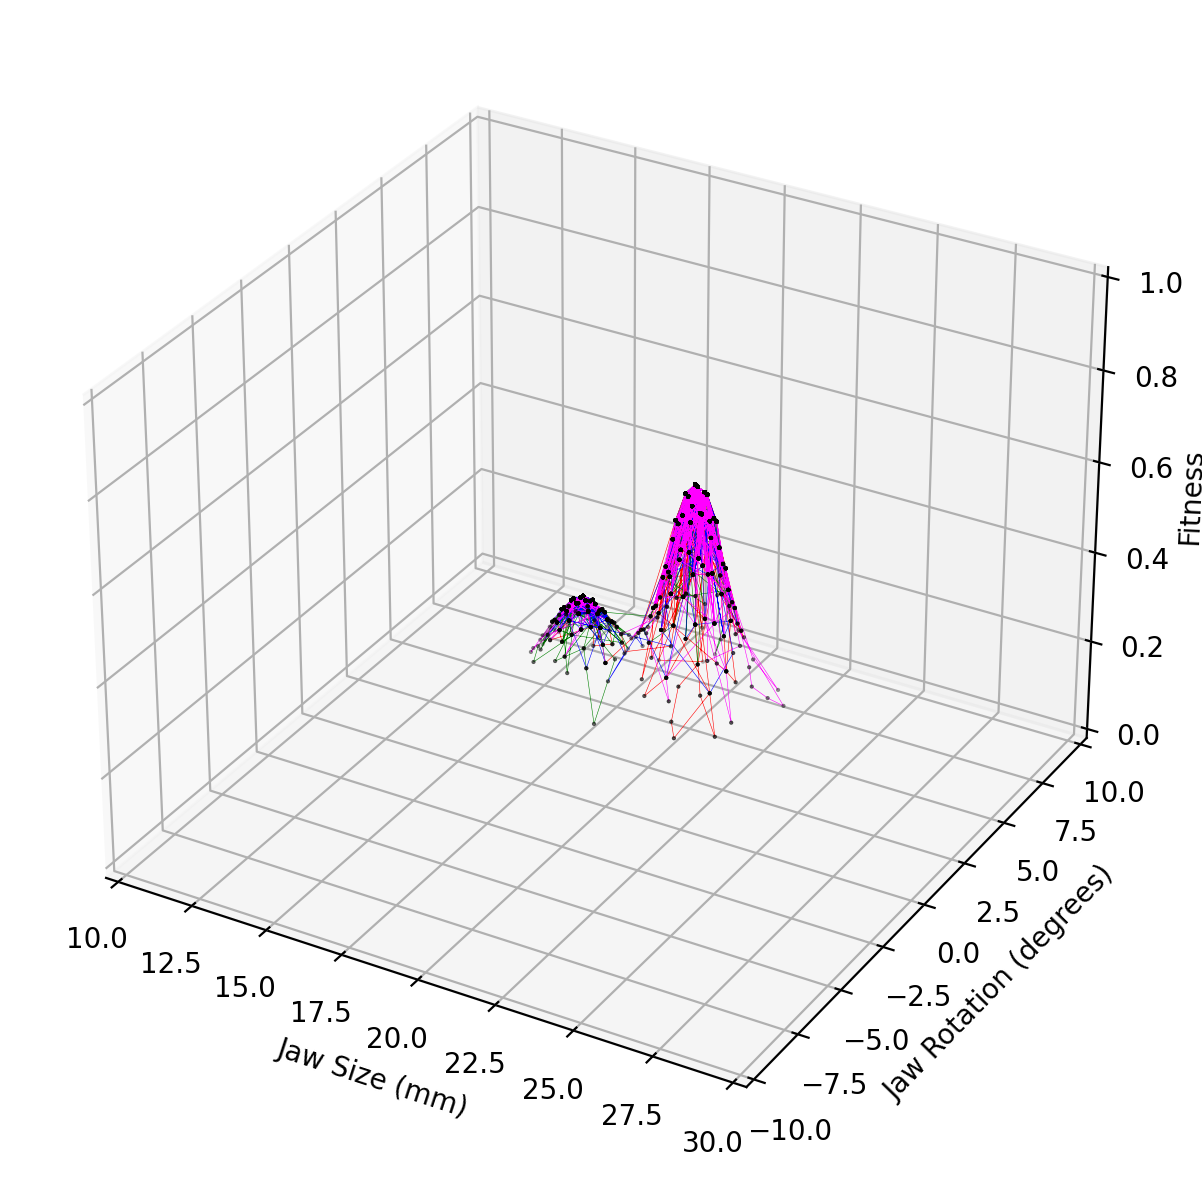

In [759]:
N = 4
dt = 10
gen = 10000
initial = np.zeros((100,100))
initial[50,50] = ff[50,50]

color = ('red','green','blue','magenta','yellow','orange','lime','aqua','purple')

fig = plt.figure(figsize=(8, 6), dpi=200)

xcordfinal = [20]*N
ycordfinal = [0]*N
fish_realfinal = [ff[50,50]]*N

metadata = dict(title='First Fitness Landscape', artist='Ellington')
writer = FFMpegWriter(fps=24, metadata=metadata)

with writer.saving(fig, "Please Work Again3.mp4", dpi=200):
    for generations in range(gen):
        xcord = []
        ycord = []
        fish_real = []

        for lineages in range(N):
            F = 0
            B = 0
            L = 0
            R = 0
            total = 0
            fishn = np.zeros((100,100))

            for i in range(100):
                for j in range(100):
                    if generations == 0:
                        if round((xcordfinal[generations]-10)*5 == i) and round((ycordfinal[generations]+10)*5 == j) and 0 < i < 99 and 0 < j < 99:
                            F = ff[i+1,j] - ff[i,j] #Determine sign and magnitude of gradient
                            B = ff[i-1,j] - ff[i,j]
                            L = ff[i,j-1] - ff[i,j]
                            R = ff[i,j+1] - ff[i,j]

                            F,B,L,R = Normalize(F,B,L,R)

                            r = np.random.random()
                            if 0 <= r < F:
                                xcord.append((i+1)/5+10)
                                ycord.append(j/5-10)

                                fish_real.append(ff[i+1,j])

                            elif F <= r < F+B:
                                xcord.append((i-1)/5+10)
                                ycord.append(j/5-10)

                                fish_real.append(ff[i-1,j])

                            elif F+B <= r < F+B+L:
                                xcord.append(i/5+10)
                                ycord.append((j-1)/5-10)

                                fish_real.append(ff[i,j-1])

                            elif F+B+L <= r < F+B+L+R:
                                xcord.append(i/5+10)
                                ycord.append((j+1)/5-10)

                                fish_real.append(ff[i,j+1])

                    else:
                        if round((xcordfinal[lineages,generations]-10)*5) == i and round((ycordfinal[lineages,generations]+10)*5) == j and 0 < i < 99 and 0 < j < 99:
                            F = ff[i+1,j] - ff[i,j] #Determine sign and magnitude of gradient
                            B = ff[i-1,j] - ff[i,j]
                            L = ff[i,j-1] - ff[i,j]
                            R = ff[i,j+1] - ff[i,j]

                            F,B,L,R = Normalize(F,B,L,R)

                            r = np.random.random()
                            if 0 <= r < F:
                                xcord.append((i+1)/5+10)
                                ycord.append(j/5-10)

                                fish_real.append(ff[i+1,j])

                            elif F <= r < F+B:
                                xcord.append((i-1)/5+10)
                                ycord.append(j/5-10)

                                fish_real.append(ff[i-1,j])

                            elif F+B <= r < F+B+L:
                                xcord.append(i/5+10)
                                ycord.append((j-1)/5-10)

                                fish_real.append(ff[i,j-1])

                            elif F+B+L <= r < F+B+L+R:
                                xcord.append(i/5+10)
                                ycord.append((j+1)/5-10)

                                fish_real.append(ff[i,j+1])

                        elif round((xcordfinal[lineages,generations]-10)*5) == i and round((ycordfinal[lineages,generations]+10)*5) == j and j == 0:
                            F = ff[i+1,j] - ff[i,j] #Determine sign and magnitude of gradient
                            B = ff[i-1,j] - ff[i,j]
                            R = ff[i,j+1] - ff[i,j]

                            F,B,R = NormalizeLeft(F,B,R)

                            r = np.random.random()
                            if 0 <= r < F:
                                xcord.append((i+1)/5+10)
                                ycord.append(j/5-10)

                                fish_real.append(ff[i+1,j])

                            elif F <= r < F+B:
                                xcord.append((i-1)/5+10)
                                ycord.append(j/5-10)

                                fish_real.append(ff[i-1,j])

                            elif F+B <= r < F+B+R:
                                xcord.append(i/5+10)
                                ycord.append((j+1)/5-10)

                                fish_real.append(ff[i,j+1])

                        elif round((xcordfinal[lineages,generations]-10)*5) == i and round((ycordfinal[lineages,generations]+10)*5) == j and j == 99:
                            F = ff[i+1,j] - ff[i,j] #Determine sign and magnitude of gradient
                            B = ff[i-1,j] - ff[i,j]
                            L = ff[i,j-1] - ff[i,j]

                            F,B,L = NormalizeRight(F,B,L)

                            r = np.random.random()
                            if 0 <= r < F:
                                xcord.append((i+1)/5+10)
                                ycord.append(j/5-10)

                                fish_real.append(ff[i+1,j])

                            elif F <= r < F+B:
                                xcord.append((i-1)/5+10)
                                ycord.append(j/5-10)

                                fish_real.append(ff[i-1,j])

                            elif F+B <= r < F+B+L:
                                xcord.append(i/5+10)
                                ycord.append((j-1)/5-10)

                                fish_real.append(ff[i,j-1])

                        elif round((xcordfinal[lineages,generations]-10)*5) == i and round((ycordfinal[lineages,generations]+10)*5) == j and i == 0:
                            F = ff[i+1,j] - ff[i,j]
                            L = ff[i,j-1] - ff[i,j]
                            R = ff[i,j+1] - ff[i,j]

                            F,L,R = NormalizeBackward(F,L,R)

                            r = np.random.random()
                            if 0 <= r < F:
                                xcord.append((i+1)/5+10)
                                ycord.append(j/5-10)

                                fish_real.append(ff[i+1,j])

                            elif F <= r < F+L:
                                xcord.append((i+1)/5+10)
                                ycord.append(j/5-10)

                                fish_real.append(ff[i,j-1])

                            elif F+L <= r < F+L+R:
                                xcord.append(i/5+10)
                                ycord.append((j+1)/5-10)

                                fish_real.append(ff[i,j+1])

                        elif round((xcordfinal[lineages,generations]-10)*5) == i and round((ycordfinal[lineages,generations]+10)*5) == j and i == 99:
                            B = ff[i-1,j] - ff[i,j]
                            L = ff[i,j-1] - ff[i,j]
                            R = ff[i,j+1] - ff[i,j]

                            B,L,R = NormalizeForward(B,L,R)

                            r = np.random.random()
                            if 0 <= r < B:
                                xcord.append((i-1)/5+10)
                                ycord.append(j/5-10)

                                fish_real.append(ff[i-1,j])

                            elif B <= r < B+L:
                                xcord.append(i/5+10)
                                ycord.append((j-1)/5-10)

                                fish_real.append(ff[i,j-1])

                            elif B+L <= r < B+L+R:
                                xcord.append(i/5+10)
                                ycord.append((j+1)/5-10)

                                fish_real.append(ff[i,j+1])

            if generations > 0 and generations % 20 == 0:
                fig.clear()
                ax = fig.add_subplot(projection='3d')
                
                plt.xlabel('Jaw Size (mm)')
                plt.ylabel('Jaw Rotation (degrees)')
                ax.set_zlabel('Fitness', rotation = 0,labelpad=0)
                plt.xlim(10,30)
                plt.ylim(-10,10)
                ax.set_zlim3d(0, 1)
                ax.scatter(xcordfinal[:,::20], ycordfinal[:,::20], fish_realfinal[:,::20], c='black', marker='.', s=1)
                ax.plot(xcordfinal[0,::20], ycordfinal[0,::20], fish_realfinal[0,::20], c=color[0], linewidth = 0.2)
                ax.plot(xcordfinal[1,::20], ycordfinal[1,::20], fish_realfinal[1,::20], c=color[1], linewidth = 0.2)
                ax.plot(xcordfinal[2,::20], ycordfinal[2,::20], fish_realfinal[2,::20], c=color[2], linewidth = 0.2)
                ax.plot(xcordfinal[3,::20], ycordfinal[3,::20], fish_realfinal[3,::20], c=color[3], linewidth = 0.2)
                fig.tight_layout()
                plt.draw()
                #plt.pause(0.05) # choose the time argument between 0.01 and 0.5
                writer.grab_frame()

        xcordfinal = np.column_stack((xcordfinal,xcord))
        ycordfinal = np.column_stack((ycordfinal,ycord))
        fish_realfinal = np.column_stack((fish_realfinal,fish_real))

### C) Displays the 2D mapping of where the species have travelled on the landscape

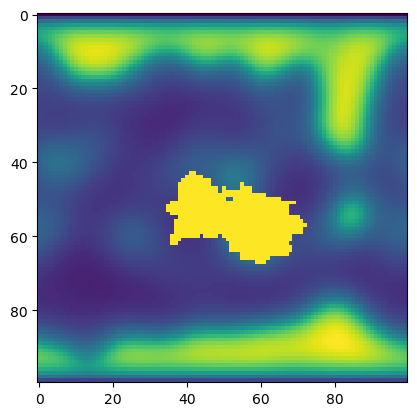

In [756]:
ffnew = np.copy(ff)

for gen in range(10000):
    for lin in range(4):
        for i in range(100):
            for j in range(100):
                if round((xcordfinal[lin,gen]-10)*5,0) == j and round((ycordfinal[lin,gen]+10)*5,0) == i:
                    ffnew[i,j] = 1
                
plt.imshow(ffnew, interpolation = 'nearest')

### D) 5 Different locations at once

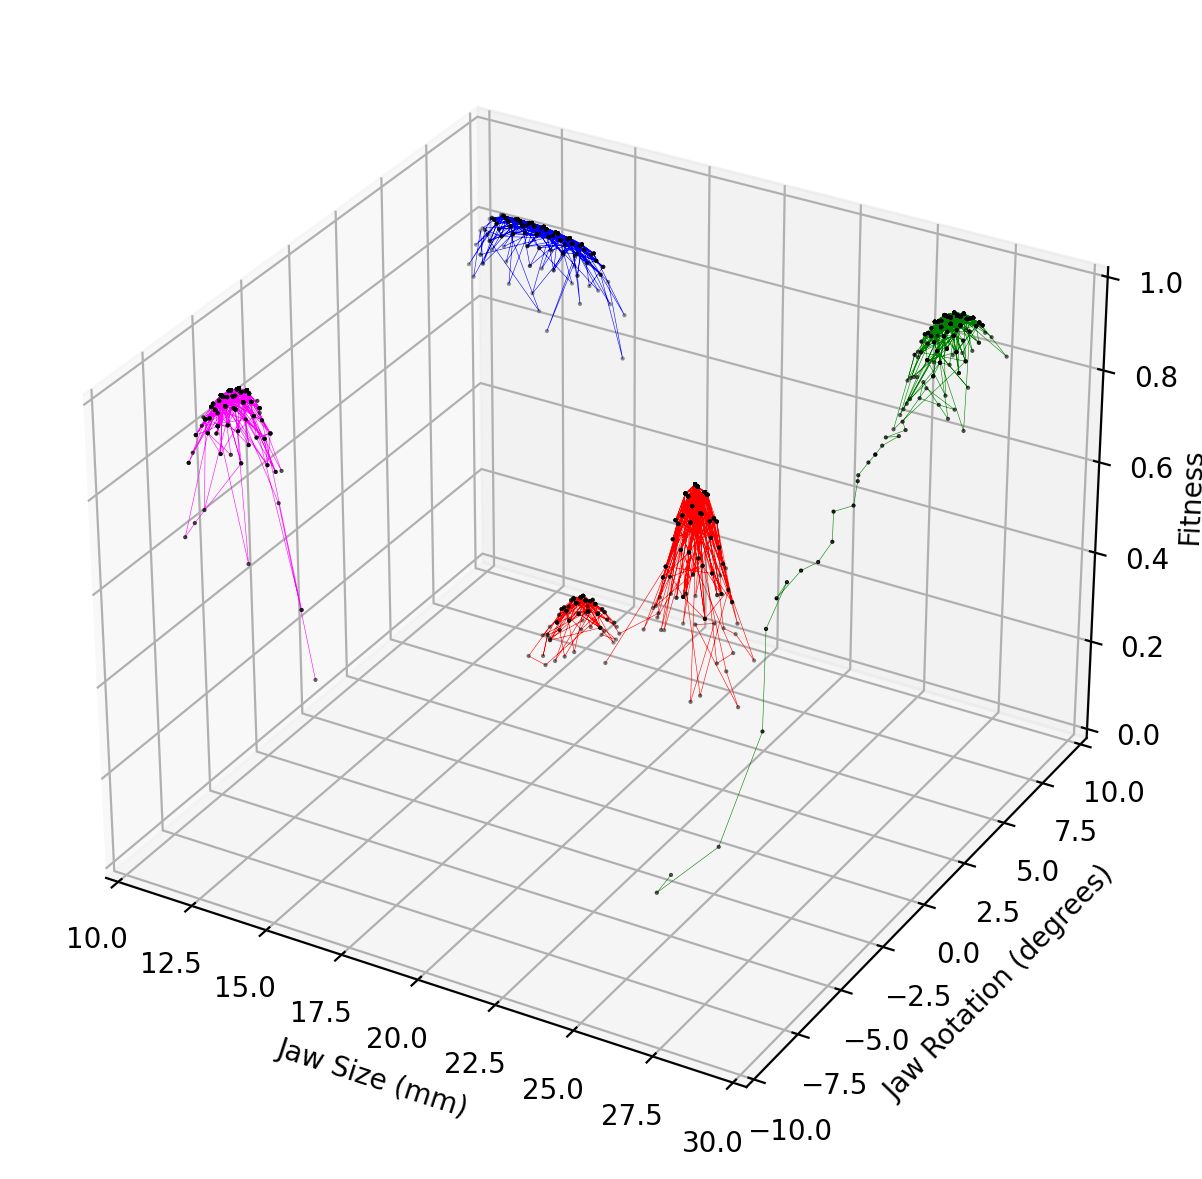

In [762]:
N = 4
dt = 10
gen = 10000

color = ('red','green','blue','magenta','yellow','orange','lime','aqua','purple')

fig = plt.figure(figsize=(8, 6), dpi=200)

xcordfinal = [20,25,14,14]
ycordfinal = [0,-5,6,-6]
fish_realfinal = [ff[50,50],ff[75,25],ff[20,80],ff[20,20]]

metadata = dict(title='First Fitness Landscape', artist='Ellington')
writer = FFMpegWriter(fps=24, metadata=metadata)

with writer.saving(fig, "Fitness_Landscape_Dif_Locations.mp4", dpi=200):
    for generations in range(gen):
        xcord = []
        ycord = []
        fish_real = []

        for lineages in range(N):
            F = 0
            B = 0
            L = 0
            R = 0
            total = 0
            fishn = np.zeros((100,100))

            for i in range(100):
                for j in range(100):
                    if generations == 0:
                        if round((xcordfinal[lineages]-10)*5 == i) and round((ycordfinal[lineages]+10)*5 == j) and 0 < i < 99 and 0 < j < 99:
                            F = ff[i+1,j] - ff[i,j] #Determine sign and magnitude of gradient
                            B = ff[i-1,j] - ff[i,j]
                            L = ff[i,j-1] - ff[i,j]
                            R = ff[i,j+1] - ff[i,j]

                            F,B,L,R = Normalize(F,B,L,R)

                            r = np.random.random()
                            if 0 <= r < F:
                                xcord.append((i+1)/5+10)
                                ycord.append(j/5-10)

                                fish_real.append(ff[i+1,j])

                            elif F <= r < F+B:
                                xcord.append((i-1)/5+10)
                                ycord.append(j/5-10)

                                fish_real.append(ff[i-1,j])

                            elif F+B <= r < F+B+L:
                                xcord.append(i/5+10)
                                ycord.append((j-1)/5-10)

                                fish_real.append(ff[i,j-1])

                            elif F+B+L <= r < F+B+L+R:
                                xcord.append(i/5+10)
                                ycord.append((j+1)/5-10)

                                fish_real.append(ff[i,j+1])

                    else:
                        if round((xcordfinal[lineages,generations]-10)*5) == i and round((ycordfinal[lineages,generations]+10)*5) == j and 0 < i < 99 and 0 < j < 99:
                            F = ff[i+1,j] - ff[i,j] #Determine sign and magnitude of gradient
                            B = ff[i-1,j] - ff[i,j]
                            L = ff[i,j-1] - ff[i,j]
                            R = ff[i,j+1] - ff[i,j]

                            F,B,L,R = Normalize(F,B,L,R)

                            r = np.random.random()
                            if 0 <= r < F:
                                xcord.append((i+1)/5+10)
                                ycord.append(j/5-10)

                                fish_real.append(ff[i+1,j])

                            elif F <= r < F+B:
                                xcord.append((i-1)/5+10)
                                ycord.append(j/5-10)

                                fish_real.append(ff[i-1,j])

                            elif F+B <= r < F+B+L:
                                xcord.append(i/5+10)
                                ycord.append((j-1)/5-10)

                                fish_real.append(ff[i,j-1])

                            elif F+B+L <= r < F+B+L+R:
                                xcord.append(i/5+10)
                                ycord.append((j+1)/5-10)

                                fish_real.append(ff[i,j+1])

                        elif round((xcordfinal[lineages,generations]-10)*5) == i and round((ycordfinal[lineages,generations]+10)*5) == j and j == 0:
                            F = ff[i+1,j] - ff[i,j] #Determine sign and magnitude of gradient
                            B = ff[i-1,j] - ff[i,j]
                            R = ff[i,j+1] - ff[i,j]

                            F,B,R = NormalizeLeft(F,B,R)

                            r = np.random.random()
                            if 0 <= r < F:
                                xcord.append((i+1)/5+10)
                                ycord.append(j/5-10)

                                fish_real.append(ff[i+1,j])

                            elif F <= r < F+B:
                                xcord.append((i-1)/5+10)
                                ycord.append(j/5-10)

                                fish_real.append(ff[i-1,j])

                            elif F+B <= r < F+B+R:
                                xcord.append(i/5+10)
                                ycord.append((j+1)/5-10)

                                fish_real.append(ff[i,j+1])

                        elif round((xcordfinal[lineages,generations]-10)*5) == i and round((ycordfinal[lineages,generations]+10)*5) == j and j == 99:
                            F = ff[i+1,j] - ff[i,j] #Determine sign and magnitude of gradient
                            B = ff[i-1,j] - ff[i,j]
                            L = ff[i,j-1] - ff[i,j]

                            F,B,L = NormalizeRight(F,B,L)

                            r = np.random.random()
                            if 0 <= r < F:
                                xcord.append((i+1)/5+10)
                                ycord.append(j/5-10)

                                fish_real.append(ff[i+1,j])

                            elif F <= r < F+B:
                                xcord.append((i-1)/5+10)
                                ycord.append(j/5-10)

                                fish_real.append(ff[i-1,j])

                            elif F+B <= r < F+B+L:
                                xcord.append(i/5+10)
                                ycord.append((j-1)/5-10)

                                fish_real.append(ff[i,j-1])

                        elif round((xcordfinal[lineages,generations]-10)*5) == i and round((ycordfinal[lineages,generations]+10)*5) == j and i == 0:
                            F = ff[i+1,j] - ff[i,j]
                            L = ff[i,j-1] - ff[i,j]
                            R = ff[i,j+1] - ff[i,j]

                            F,L,R = NormalizeBackward(F,L,R)

                            r = np.random.random()
                            if 0 <= r < F:
                                xcord.append((i+1)/5+10)
                                ycord.append(j/5-10)

                                fish_real.append(ff[i+1,j])

                            elif F <= r < F+L:
                                xcord.append((i+1)/5+10)
                                ycord.append(j/5-10)

                                fish_real.append(ff[i,j-1])

                            elif F+L <= r < F+L+R:
                                xcord.append(i/5+10)
                                ycord.append((j+1)/5-10)

                                fish_real.append(ff[i,j+1])

                        elif round((xcordfinal[lineages,generations]-10)*5) == i and round((ycordfinal[lineages,generations]+10)*5) == j and i == 99:
                            B = ff[i-1,j] - ff[i,j]
                            L = ff[i,j-1] - ff[i,j]
                            R = ff[i,j+1] - ff[i,j]

                            B,L,R = NormalizeForward(B,L,R)

                            r = np.random.random()
                            if 0 <= r < B:
                                xcord.append((i-1)/5+10)
                                ycord.append(j/5-10)

                                fish_real.append(ff[i-1,j])

                            elif B <= r < B+L:
                                xcord.append(i/5+10)
                                ycord.append((j-1)/5-10)

                                fish_real.append(ff[i,j-1])

                            elif B+L <= r < B+L+R:
                                xcord.append(i/5+10)
                                ycord.append((j+1)/5-10)

                                fish_real.append(ff[i,j+1])

            if generations > 0 and generations % 20 == 0:
                fig.clear()
                ax = fig.add_subplot(projection='3d')
                
                plt.xlabel('Jaw Size (mm)')
                plt.ylabel('Jaw Rotation (degrees)')
                ax.set_zlabel('Fitness', rotation = 0,labelpad=0)
                plt.xlim(10,30)
                plt.ylim(-10,10)
                ax.set_zlim3d(0, 1)
                ax.scatter(xcordfinal[:,::20], ycordfinal[:,::20], fish_realfinal[:,::20], c='black', marker='.', s=1)
                ax.plot(xcordfinal[0,::20], ycordfinal[0,::20], fish_realfinal[0,::20], c=color[0], linewidth = 0.2)
                ax.plot(xcordfinal[1,::20], ycordfinal[1,::20], fish_realfinal[1,::20], c=color[1], linewidth = 0.2)
                ax.plot(xcordfinal[2,::20], ycordfinal[2,::20], fish_realfinal[2,::20], c=color[2], linewidth = 0.2)
                ax.plot(xcordfinal[3,::20], ycordfinal[3,::20], fish_realfinal[3,::20], c=color[3], linewidth = 0.2)
                fig.tight_layout()
                plt.draw()
                #plt.pause(0.05) # choose the time argument between 0.01 and 0.5
                writer.grab_frame()

        xcordfinal = np.column_stack((xcordfinal,xcord))
        ycordfinal = np.column_stack((ycordfinal,ycord))
        fish_realfinal = np.column_stack((fish_realfinal,fish_real))

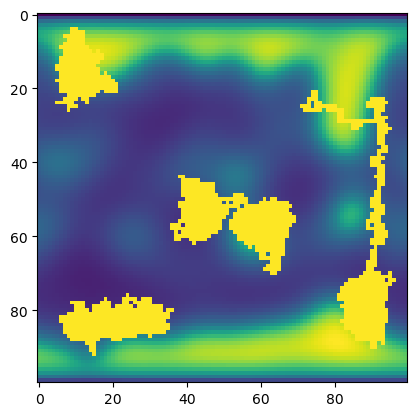

In [763]:
ffnew = np.copy(ff)

for gen in range(10000):
    for lin in range(4):
        for i in range(100):
            for j in range(100):
                if round((xcordfinal[lin,gen]-10)*5,0) == j and round((ycordfinal[lin,gen]+10)*5,0) == i:
                    ffnew[i,j] = 1
                
plt.imshow(ffnew, interpolation = 'nearest')